In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

import datetime
import xgboost as xgb
from sklearn.impute import SimpleImputer
from tqdm import tqdm

In [2]:
pcr = pd.read_excel("Test_dataset.xlsx", sheet_name=1, header=1)

In [3]:
pcr.describe()

,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00
count,2902.000000,3329.000000,3274.000000,3317.000000,3226.000000,3092.000000
mean,0.938828,0.825080,0.960627,1.220309,1.165254,1.201216
std,0.201421,0.242701,0.276744,0.348401,0.390495,0.441742
min,0.600000,0.420000,0.498800,0.638488,0.515107,0.462070
25%,0.762500,0.612000,0.717680,0.914277,0.823990,0.811109
50%,0.930000,0.816000,0.950240,1.207302,1.152179,1.181962
75%,1.110000,1.032000,1.196480,1.517565,1.499673,1.574630
max,1.290000,1.248000,1.442720,1.827827,1.847166,1.967298


In [4]:
# storing the Stock_index for later use
Stock_Index = pcr['Unnamed: 0']
pcr = pcr.drop(labels='Unnamed: 0', axis=1)
pcr = pcr.transpose()

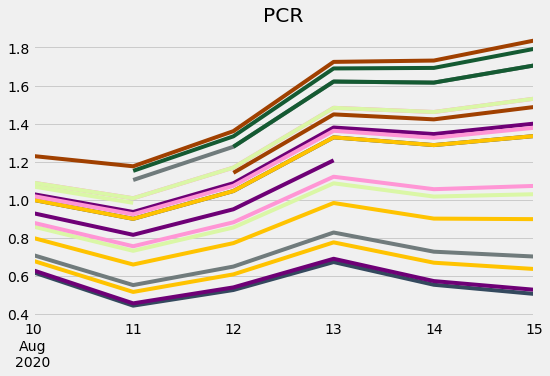

In [5]:
# defined a small color palette to cycle for different stocks
color_palette = ["#34495E", "#FFC300", "#DAF7A6", "#6E0076", "#FF96D5", "#707B7C", "#145A32", "#A04000"]
for i in range(20):
    _ = pcr[i].plot(style='-', figsize=(8,5), color=color_palette[(i+1)%8], title='PCR')

The omissions are due to missing values

# Imputing the missing values

In [6]:
# This value is the same value imputed using combination of larger dataset
pcr.loc[pcr.index.tolist()[0]].fillna(0.943045, inplace=True)
mean_imputer = SimpleImputer()
indices = pcr.index
pcr = pd.DataFrame(mean_imputer.fit_transform(pcr.transpose())).transpose()
pcr.index = indices

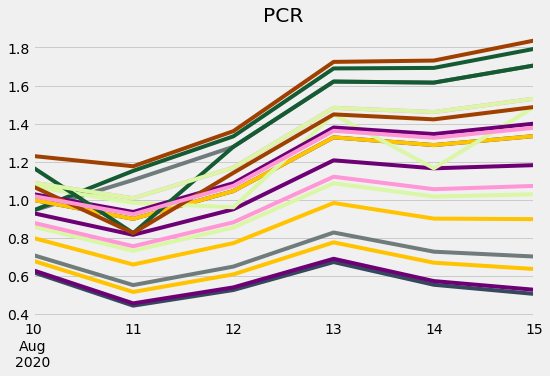

In [7]:
# plotting the values again
for i in range(20):
    _ = pcr[i].plot(style='-', figsize=(8,5), color=color_palette[(i+1)%8], title='PCR')

# Train Test Split

In [8]:
split_date = indices[3]
pcr_train = pcr.loc[pcr.index<=split_date].copy()
pcr_valid = pcr.loc[pcr.index>split_date].copy()

## Create Features

In [9]:
def create_feat(df, label=None):
    df['date'] = df.index
    df['hr'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hr','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label is not None :
        y = df[label]
        return X, y
    return X

# Model creation and fitting to a single data column

In [10]:
df_train = pd.DataFrame(pcr_train[0].copy())
df_valid = pd.DataFrame(pcr_valid[0].copy())
X_train, y_train = create_feat(df_train, 0)
X_valid, y_valid = create_feat(df_valid, 0)

In [11]:
model = xgb.XGBRegressor(
    n_estimators=1000,
)
model.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_valid, y_valid)],
         early_stopping_rounds=20,
         verbose=True)

[0]	validation_0-rmse:0.25849	validation_1-rmse:0.32686
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.21043	validation_1-rmse:0.27142
[2]	validation_0-rmse:0.17682	validation_1-rmse:0.22929
[3]	validation_0-rmse:0.14953	validation_1-rmse:0.18783
[4]	validation_0-rmse:0.12710	validation_1-rmse:0.14715
[5]	validation_0-rmse:0.10803	validation_1-rmse:0.11256
[6]	validation_0-rmse:0.09183	validation_1-rmse:0.08317
[7]	validation_0-rmse:0.07805	validation_1-rmse:0.05818
[8]	validation_0-rmse:0.06635	validation_1-rmse:0.03695
[9]	validation_0-rmse:0.05639	validation_1-rmse:0.01893
[10]	validation_0-rmse:0.04793	validation_1-rmse:0.00380
[11]	validation_0-rmse:0.04075	validation_1-rmse:0.00962
[12]	validation_0-rmse:0.03463	validation_1-rmse:0.02065
[13]	validation_0-rmse:0.02944	validation_1-rmse:0.03006
[14]	validation_0-rmse:0.02502	validation_1-rmse:0.03

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

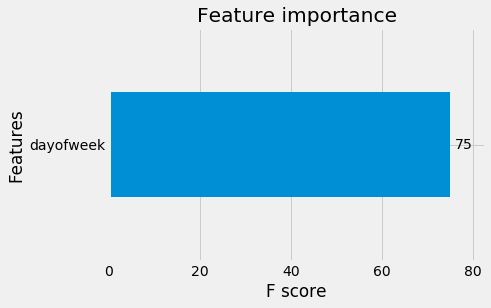

In [12]:
_ = xgb.plot_importance(model, height=0.9)

## creating 16 Aug feaure vector

In [13]:
X_test_v = pd.DataFrame()
X_test_v[0]=pd.Series(datetime.datetime(2020,8,16,0,0))
X_test_v.set_index(0, inplace=True)
X_test_v = create_feat(X_test_v)

# The Model

In [14]:
def model_predict(X_train, y_train, X_valid, y_valid):
    model = xgb.XGBRegressor(
        n_estimators=1000,
    )
    model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_valid, y_valid)],
             early_stopping_rounds=20,
             verbose=False)
    return model.predict(X_test_v)

In [15]:
def data_creator():
    X_t = pd.DataFrame()
    for i in tqdm(range(pcr_train.shape[1])):
        X_train, y_train = create_feat(pd.DataFrame(pcr_train[i].copy()), i)
        X_valid, y_valid = create_feat(pd.DataFrame(pcr_valid[i].copy()), i)
        value = model_predict(X_train, y_train, X_valid, y_valid)
        X_t[i] = value
    return X_t

In [16]:
X_test = data_creator()

100%|██████████| 3331/3331 [01:38<00:00, 33.99it/s]


In [17]:
X_test.index = X_test_v.index
X_test

,0,1,2,3,4,5,6,7,8,9,...,3321,3322,3323,3324,3325,3326,3327,3328,3329,3330
0,,,,,,,,,,,,,,,,,,,,,
2020-08-16,0.896263,1.023545,1.173586,1.482017,1.61998,1.688867,1.723325,1.310791,1.310791,1.329876,...,1.023545,0.520773,0.800266,1.290895,1.332564,1.023545,0.580044,0.640398,0.881658,0.770245


# Visualizing after appending it to the original data

In [18]:
appended_data = pd.concat([pcr, X_test])

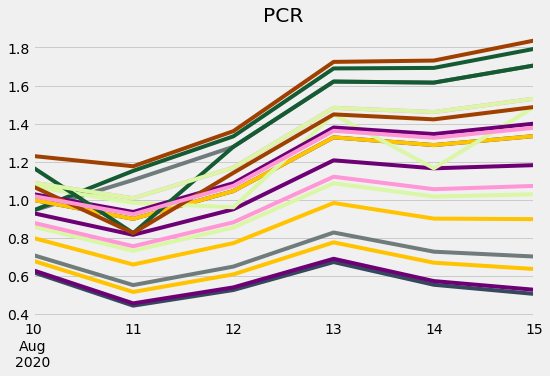

In [19]:
# plotting the new values
for i in range(20):
    _ = pcr[i].plot(style='-', figsize=(8,5), color=color_palette[(i+1)%8], title='PCR')
    
# as we observe here, it trends here

# Price Prediction

### For this task I replace the PCR in the first sheet of test data and run the predictor saved before

In [20]:
HackPrice = xgb.Booster()
HackPrice.load_model('HackPrice.model')

In [21]:
test_data = pd.read_csv("Test_data_A")

In [22]:
test_data["Put-Call Ratio"] = X_test.values.T

# Generating submission

In [23]:
y_test = HackPrice.predict(xgb.DMatrix(test_data.values))

In [24]:
submission = pd.DataFrame()
submission['Stock Index'] = Stock_Index
submission['Stock Price'] = y_test

In [25]:
submission.head()

,Stock Index,Stock Price
0,AC3235,815.763611
1,AC3236,259.277161
2,AC3237,1577.216431
3,AC3238,877.741455
4,AC3239,277.966766


In [26]:
# saving into submission2.csv
submission.to_csv("submission2.csv", index=False)